In [1]:
import datasets as ds
from MNIST_functions import *

In [2]:
permuted_train_loaders, permuted_test_loaders, rotated_train_loaders, rotated_test_loaders = ds.load_datasets()

In [3]:
epoch_accuracies_A1, epoch_accuracies_B1, epoch_accuracies_C1, epoch_accuracies_A2, epoch_accuracies_B2, epoch_accuracies_C2, epoch_accuracies_A3, epoch_accuracies_B3, epoch_accuracies_C3,  epoch_accuracies_A1_ewc, epoch_accuracies_B1_ewc, epoch_accuracies_C1_ewc, epoch_accuracies_A2_ewc, epoch_accuracies_B2_ewc, epoch_accuracies_C2_ewc, epoch_accuracies_A3_ewc, epoch_accuracies_B3_ewc, epoch_accuracies_C3_ewc, epoch_accuracies_A1_L2, epoch_accuracies_B1_L2, epoch_accuracies_C1_L2, epoch_accuracies_A2_L2, epoch_accuracies_B2_L2, epoch_accuracies_C2_L2, epoch_accuracies_A3_L2, epoch_accuracies_B3_L2, epoch_accuracies_C3_L2 = run_experiment_2A( permuted_train_loaders, permuted_test_loaders)

Learning rate: 0.001, Dropout input: 0.0, Dropout hidden: 0.0, Early stopping: False, Num hidden layers: 2, Width hidden layers: 400, Epochs: 20
Epoch 1/20, Accuracy on test set A: 0.9425
Epoch 2/20, Accuracy on test set A: 0.9556
Epoch 3/20, Accuracy on test set A: 0.9613
Epoch 4/20, Accuracy on test set A: 0.9628
Epoch 5/20, Accuracy on test set A: 0.9636
Epoch 6/20, Accuracy on test set A: 0.9658
Epoch 7/20, Accuracy on test set A: 0.9687
Epoch 8/20, Accuracy on test set A: 0.9710
Epoch 9/20, Accuracy on test set A: 0.9705
Epoch 10/20, Accuracy on test set A: 0.9695
Epoch 11/20, Accuracy on test set A: 0.9705
Epoch 12/20, Accuracy on test set A: 0.9704
Epoch 13/20, Accuracy on test set A: 0.9713
Epoch 14/20, Accuracy on test set A: 0.9720
Epoch 15/20, Accuracy on test set A: 0.9726
Epoch 16/20, Accuracy on test set A: 0.9718
Epoch 17/20, Accuracy on test set A: 0.9724
Epoch 18/20, Accuracy on test set A: 0.9721
Epoch 19/20, Accuracy on test set A: 0.9718
Epoch 20/20, Accuracy on tes

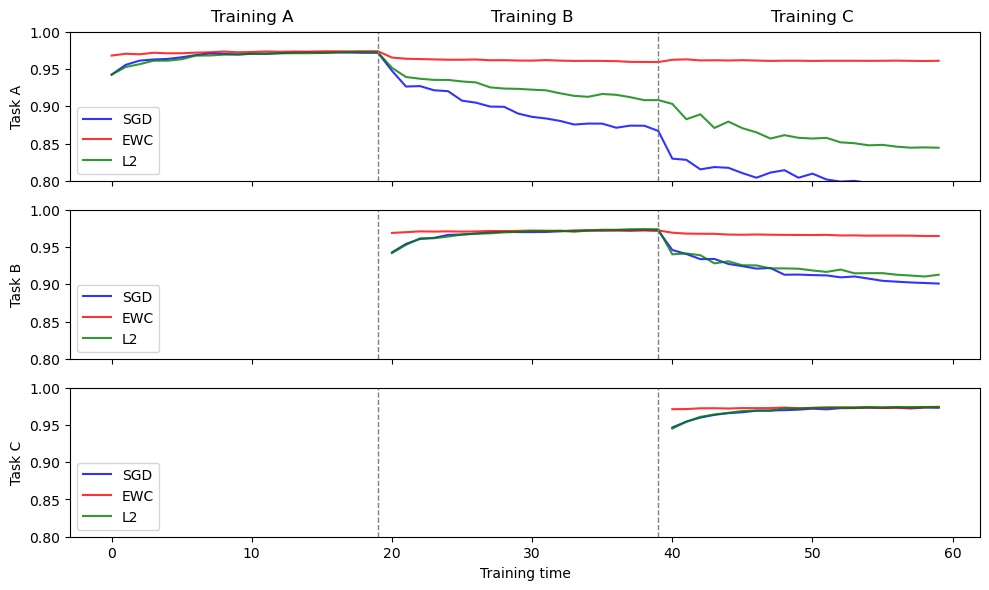

In [59]:
import numpy as np
import matplotlib.pyplot as plt

sgd_A = [epoch_accuracies_A1, epoch_accuracies_A2, epoch_accuracies_A3] 
ewc_A = [epoch_accuracies_A1_ewc, epoch_accuracies_A2_ewc, epoch_accuracies_A3_ewc] 
l2_A = [epoch_accuracies_A1_L2, epoch_accuracies_A2_L2, epoch_accuracies_A3_L2] 

sgd_B = [epoch_accuracies_B1, epoch_accuracies_B2, epoch_accuracies_B3] 
ewc_B = [epoch_accuracies_B1_ewc, epoch_accuracies_B2_ewc, epoch_accuracies_B3_ewc] 
l2_B = [epoch_accuracies_B1_L2, epoch_accuracies_B2_L2, epoch_accuracies_B3_L2] 

sgd_C = [epoch_accuracies_C1, epoch_accuracies_C2, epoch_accuracies_C3] 
ewc_C = [epoch_accuracies_C1_ewc, epoch_accuracies_C2_ewc, epoch_accuracies_C3_ewc] 
l2_C = [epoch_accuracies_C1_L2, epoch_accuracies_C2_L2, epoch_accuracies_C3_L2] 

# Flatten each list (SGD, EWC, L2) into a single list of accuracies for each task
sgd_A_flat = [item for sublist in sgd_A for item in sublist]
ewc_A_flat = [item for sublist in ewc_A for item in sublist]
l2_A_flat = [item for sublist in l2_A for item in sublist]

sgd_B_flat = [item for sublist in sgd_B for item in sublist]
ewc_B_flat = [item for sublist in ewc_B for item in sublist]
l2_B_flat = [item for sublist in l2_B for item in sublist]

sgd_C_flat = [item for sublist in sgd_C for item in sublist]
ewc_C_flat = [item for sublist in ewc_C for item in sublist]
l2_C_flat = [item for sublist in l2_C for item in sublist]

# Create time arrays for the x-axis 
max_len_A = len(sgd_A_flat)  # The total number of points for Task A
time_A = np.arange(max_len_A)

# Task B and C - create time arrays based on the available epochs
max_len_B = len(sgd_B_flat)
time_B = np.arange(max_len_B)

max_len_C = len(sgd_C_flat)
time_C = np.arange(max_len_C)

# Padding with NaNs for Task B (before the last 40 epochs) and Task C (before the last 20 epochs)
sgd_B_padded = [np.nan] * (max_len_A - max_len_B) + sgd_B_flat
ewc_B_padded = [np.nan] * (max_len_A - max_len_B) + ewc_B_flat
l2_B_padded = [np.nan] * (max_len_A - max_len_B) + l2_B_flat

sgd_C_padded = [np.nan] * (max_len_A - max_len_C) + sgd_C_flat
ewc_C_padded = [np.nan] * (max_len_A - max_len_C) + ewc_C_flat
l2_C_padded = [np.nan] * (max_len_A - max_len_C) + l2_C_flat

# Adjust time arrays for Task B and C based on the length of padded data
time_B_padded = np.arange(len(sgd_B_padded))
time_C_padded = np.arange(len(sgd_C_padded))

# Set up subplots (3 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True)

# Colors for the methods
colors = {'ewc': 'red', 'l2': 'green', 'sgd': 'blue'}

# Plot Task A
axes[0].plot(time_A, sgd_A_flat, label="SGD", color=colors['sgd'], alpha=0.8)
axes[0].plot(time_A, ewc_A_flat, label="EWC", color=colors['ewc'], alpha=0.8)
axes[0].plot(time_A, l2_A_flat, label="L2", color=colors['l2'], alpha=0.8)
axes[0].axvline(x=19, color='gray', linestyle='--', linewidth=1)
axes[0].axvline(x=39, color='gray', linestyle='--', linewidth=1)
axes[0].set_ylabel("Task A")
axes[0].set_ylim(0.8, 1)
axes[0].legend(loc="lower left")
axes[0].text(10, 1.01, "Training A", ha='center', va='bottom', fontsize=12)
axes[0].text(30, 1.01, "Training B", ha='center', va='bottom', fontsize=12)
axes[0].text(50, 1.01, "Training C", ha='center', va='bottom', fontsize=12)

# Plot Task B
axes[1].plot(time_B_padded, sgd_B_padded, label="SGD", color=colors['sgd'], alpha=0.8)
axes[1].plot(time_B_padded, ewc_B_padded, label="EWC", color=colors['ewc'], alpha=0.8)
axes[1].plot(time_B_padded, l2_B_padded, label="L2", color=colors['l2'], alpha=0.8)
axes[1].axvline(x=19, color='gray', linestyle='--', linewidth=1)
axes[1].axvline(x=39, color='gray', linestyle='--', linewidth=1)
axes[1].set_ylabel("Task B")
axes[1].set_ylim(0.8, 1)
axes[1].legend(loc="lower left")

# Plot Task C
axes[2].plot(time_C_padded, sgd_C_padded, label="SGD", color=colors['sgd'], alpha=0.8)
axes[2].plot(time_C_padded, ewc_C_padded, label="EWC", color=colors['ewc'], alpha=0.8)
axes[2].plot(time_C_padded, l2_C_padded, label="L2", color=colors['l2'], alpha=0.8)
axes[2].axvline(x=19, color='gray', linestyle='--', linewidth=1)
axes[2].axvline(x=39, color='gray', linestyle='--', linewidth=1)
axes[2].set_xlabel("Training time")
axes[2].set_ylabel("Task C")
axes[2].set_ylim(0.8, 1)
axes[2].legend(loc="lower left")

# Show the plot
plt.tight_layout()
plt.show()

In [3]:
run_experiment_2B_with_ewc(permuted_train_loaders)

Trial 1/50: Learning rate=0.00009, Hidden layer width=1133
Training on Task 1
Task 1, Epoch 1/100, SGD Loss: 2.9874, EWC Loss: 2.8792
Validation Loss on Task 1, Epoch 1, SGD: 0.5362, EWC: 0.5247
Task 1, Epoch 2/100, SGD Loss: 1.1535, EWC Loss: 1.1047
Validation Loss on Task 1, Epoch 2, SGD: 0.3667, EWC: 0.3698
Task 1, Epoch 3/100, SGD Loss: 0.8141, EWC Loss: 0.8174
Validation Loss on Task 1, Epoch 3, SGD: 0.2983, EWC: 0.2964
Task 1, Epoch 4/100, SGD Loss: 0.6585, EWC Loss: 0.6550
Validation Loss on Task 1, Epoch 4, SGD: 0.2567, EWC: 0.2589
Task 1, Epoch 5/100, SGD Loss: 0.5673, EWC Loss: 0.5606
Validation Loss on Task 1, Epoch 5, SGD: 0.2354, EWC: 0.2371
Task 1, Epoch 6/100, SGD Loss: 0.5118, EWC Loss: 0.5038
Validation Loss on Task 1, Epoch 6, SGD: 0.2171, EWC: 0.2200
Task 1, Epoch 7/100, SGD Loss: 0.4690, EWC Loss: 0.4616
Validation Loss on Task 1, Epoch 7, SGD: 0.2042, EWC: 0.2086
Task 1, Epoch 8/100, SGD Loss: 0.4352, EWC Loss: 0.4271
Validation Loss on Task 1, Epoch 8, SGD: 0.1960

KeyboardInterrupt: 